$\newcommand{\ket}[1]{|#1\rangle}$

In [16]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_santiago') #provider.get_backend('gép_neve_ide') #töltsd be a kiválasztott gépet

ibmqfactory.load_account:WARNING:2022-03-27 21:05:27,708: Credentials are already in use. The existing account in the session will be replaced.


# Projekt: Relaxációs idő kimérése

A qubitek kölcsönhatnak a környezetükkel, ezért a bennük tárolt kvantuminformáció fokozatosan eltűnik. Szupravezető qubitek esetében a legjelentősebb külső kölcsönhatások a qubitek abszorpciója és emissziója. Abszorpció akkor következik be, amikor a qubit a környezetéből elnyel egy fotont és a $\ket{0}$ állapotból az $\ket{1}$ állapotba kerül. Emisszió során pedig a qubit kibocsájt egy fotont és az $\ket{1}$ állapotból a $\ket{0}$ állapotba kerül. Ezeknek a folyamatoknak a bekövetkezési valószínűsége függ a hőmérséklettől, ezért minél alacsonyabb hőmérsékleten van a qubit, annál tovább képes megtartani a benne kódolt kvantuminformációt.

### Relaxációs idő

A fentebb ismertetett folyamatok miatt, ha egy qubitet beállítunk az $\ket{1}$ állapotba 0 Kelvinhez közeli hőmérsékleten, akkor egy idő után a qubit relaxálódni fog a $\ket{0}$ állapotba. Annak a valószínűsége, hogy a qubitet az $\ket{1}$ állapotban találjuk idővel exponenciálisan csökken $$P(t) = a e^{-t/T_1} + b,$$
ahol $P(t)$ annak a valószínűsége, hogy a qubitet $t$ idő után az $\ket{1}$ állapotban találjuk, $T_1$ a qubitre jellemző relaxációs idő, $a$ és $b$ paraméterek pedig a qubitre, hőmérsékletre és a kiolvasásra jellemző egyéb konstansok.

Az IBM kvantumszámítógépeinek qubitjei egy 10-20 mK hőméréskletű hűtőben vannak elhelyezve, és a relaxációs idejük tipikus értéke 100 mikroszekundum. Ez azt jelenti, hogy körülbelül ennyi ideig lehet a qubiteket érdemlegesen használni egy kvantumalgortimus során, ami egy elég komoly limitáció, és ez az egyik oka annak, hogy a jelenlegi kvantumszámítógépek nem képesek elérni a teljes potenciáljukat.

### Mérés menete

A relaxációs idő meghatározásához a qubitet az $\ket{1}$ állapotba helyezzük majd $t$ idő után megmérjük a qubit állapotát.
Ha egy adott $t$ mérési idővel ezt a mérést sokszor megismételjük, akkor az eredményekből megtudjuk határozni annak valószínűsgét, hogy $t$ idő után a qubitet az $\ket{1}$ állapotban találjuk, így keletkezik egy idő-valószínűség adatpárunk. Ha ezzel a módszerrel kellően sok idő-valószínűség adatpárt kimérünk, meg tudjuk határozni a relaxációs időt a $$P(t) = a e^{-t/T_1} + b$$
képlet alapján.

### Adatok kiértékelése

A mérések elvégézése után rendelkezésünkre állnak idő-valószínűség adatpárok. Ha ábrázoljuk az adatpontokat, akkor egy exponenciálisan lecsengő függvényt kell látnunk. Ahhoz, hogy meghatározzuk a relaxációs időt, meg kell találni azokat a $a$, $b$ és $T_1$ paramétereket amelyek esetében a $P(t) = a e^{-t/T_1} + b$ függvény legjobban illeszkedik az adatpontokra.

## Projekt feladatok

Fejezd be a `meas_circuit` függvényt ami létrehozza a mérőáramkört! A függvény bemenete legyen a várakozási idő $t$ mikroszekundumban, és a kimenete egy kvantumáramkör ami a qubitet az $\ket{1}$ állapotba állítja majd $t$ idő után végrehajt egy mérést a qubiten. A függvény vázát lásd lentebb. Használd a [delay](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.delay.html) instrukciót a mérési idő beállításához. Állítsd be, hogy az időt mikroszkendumban értelmezze a delay instrukció.

In [7]:
def meas_circuit(t):
    qc = QuantumCircuit(1, 1) #egy qubites kvantumáramkör egy klasszikus bittel
    #megoldás ide
    qc.x(0)
    qc.delay(t, 0, unit = 'us')
    qc.measure(0, 0)
    return qc

Válassz ki ötven darab különböző mérési időt. Probáld úgy választani őket, hogy egyenletesen lefedjék a 0-300 mikroszekundumos intervallumot. A kiválasztott mérési időket tárold el egy python listában.

In [8]:
#megoldás
N = 50 #number of measurement intervals
T = 300 #largest measurment interval in us
meas_intervals = [T * (i + 1) / N for i in range(N)]

Futtasd le a `measure_T1` függvényt, ami létrehozza a mérőáramköröket és lefuttatja azokat a kiválasztott gépen. A függvény első argumentuma az előbb létrehozott python lista, ami a mérési intervallumokat tartalmazza, a második argument pedig azt adja meg, hogy az egyes mérőáramköröket hányszor futtasa le a kvantumszámítógép. A második argumentum legyen egy 4096 és 8192 közötti érték. A függvény kimenete egy IBMQJob munkafolyamat ezt tárold egy változóban.

In [9]:
def measure_T1(meas_intervals, shots):
    meas_circuits = [meas_circuit(t) for t in meas_intervals]
    trans_meas_circuits = transpile(meas_circuits, backend = backend, optimization_level = 0, scheduling_method='alap')
    job = backend.run(trans_meas_circuits, shots = shots)
    return job

In [82]:
#megoldás
job = measure_T1(meas_intervals, 2**13)

Ha sikerült lefuttatnod a `measure_T1` függvényt ellenőrizd le az IBM Q weboldalán, hogy a munkafolyamat megjelent a Jobs fülnél! Várd meg amíg le fut a munkafolyamat, ez akár órákba is telhet.

Amíg várakozol egészítsd ki a `get_probs` függvényt, aminek a bemenete a `measure_T1` függvény által létrehozott munkafolyamat, és a visszatérési értéke egy lista ami az $\ket{1}$ mérési kimenet valószínűségeit tartalmazza.

In [10]:
def get_probs(job):
    probs = []
    for c in job.result().get_counts():
        one_count = c['1'] # az |1> mérési kimenetek száma
        zero_count = c['0'] # a |0> mérési kimenetek száma
        #számold ki a one_count és zero_count változók segítségével annak a valószínűsgét, hogy a mérési eredmény |1>
        P = one_count / (one_count + zero_count) #megoldásod ide
        probs.append(P) #a kiszámolt valószínűséget a probs lista végéhez fűzi
    return probs #visszatér a valószínűségekkel

Miután lefutott a munkafolyamat, futtasd le a `get_probs` függvényt! A matplotlib csomag scatter függvénye segítségével ábrázold a mért valószínúségeket a mérési idő függvényében!

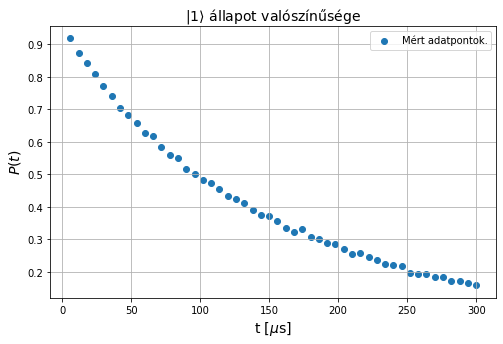

In [19]:
#megoldás
probs = get_probs(job)

fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(meas_intervals, probs, label = "Mért adatpontok.")
ax.set_xlabel(r"t [$\mu$s]", size = 14)
ax.set_ylabel(r"$P(t)$", size = 14)
ax.set_title(r"$|1\rangle$ állapot valószínűsége", size = 14)
ax.legend()
ax.grid()

A `fit_exp` függvény segítségével meg lehet keresni az ideális $a$, $b$ és $T_1$ paramétereket, amikre a $P(t) = a e^{-t/T_1} + b$ függvény a legjobban illeszkedik az adatpontokra. A függvény első argumentuma a kiválasztott mérési időket tartalmazó lista, a második argumentum pedig a kiszámolt valószínűségeket tartalmazó lista. A többi argumentum opcionális, ideális esetben ezekkel nem kell foglalkozni. A függvény visszatérési értéke egy három elemű lista aminek az elemei sorrendben az $a$, $b$, és $T_1$ paraméterek optimális értéke.

A `fit_exp` függvénnyel határozd meg a $T_1$ relaxációs időt a mért adatok alapján! Készíts még egy ábrát amin láthatóak a mért adatpontok illetve az illesztett függvény!

In [14]:
def P(t, a, b, T1):
    return a * np.exp(-t / T1) + b
    
def fit_exp(meas_intervals, probs, a = 1, b = 0, T1 = 100): 
    p, c = curve_fit(P, meas_intervals, probs, p0 = [a, b, T1])
    return p

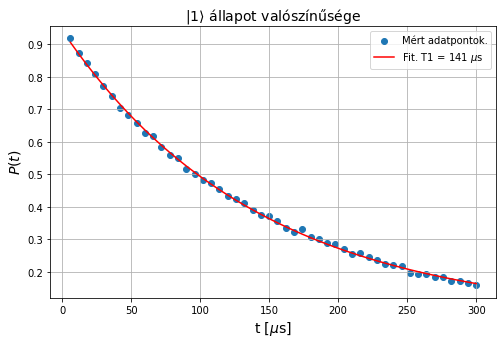

In [15]:
#megoldás
p = fit_exp(meas_intervals, probs)
fig2, ax2 = plt.subplots(1, 1, figsize = (8, 5))
ax2.scatter(meas_intervals, probs, label = "Mért adatpontok.")
ax2.plot(meas_intervals, [P(t, *p) for t in meas_intervals], c = "red", label = "Fit. T1 = $%.0f$ $\mu$s" % p[2])
ax2.set_xlabel(r"t [$\mu$s]", size = 14)
ax2.set_ylabel(r"$P(t)$", size = 14)
ax2.set_title(r"$|1\rangle$ állapot valószínűsége", size = 14)
ax2.legend()
ax2.grid()
